In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import time

In [4]:
start_date = '2013-10-14'
#marketCap_selection = 'on_chain' 
marketCap_selection = 'off_chain' 

In [5]:
response = requests.get('https://coinmetrics.io/newdata/btc.csv')
file_object = io.StringIO(response.content.decode('utf-8'))
data = pd.read_csv(file_object)
data = data[['date', 'SplyCur', 'CapMrktCurUSD', 'CapRealUSD']]
data.columns = ['Date', 'Supply', 'CapMrktCurUSD', 'CapRealUSD']
data['Date'] = pd.to_datetime(data['Date'])

if marketCap_selection == 'on_chain':
    data = data[['Date', 'Supply', 'CapRealUSD']]
else:
    data = data[['Date', 'Supply', 'CapMrktCurUSD']]

data.columns = ['Date', 'Supply', 'MarketCap']
data['Price'] = data['MarketCap'] / data['Supply']
data.set_index('Date', inplace = True)
data = data[start_date:]
data.reset_index('Date',inplace = True)
data.head()

,Date,Supply,MarketCap,Price
0,2013-10-14,1.184266e+07,1.602777e+09,135.339195
1,2013-10-15,1.184916e+07,1.676585e+09,141.493909
2,2013-10-16,1.185441e+07,1.639797e+09,138.327922
3,2013-10-17,1.185859e+07,1.704638e+09,143.747134
4,2013-10-18,1.186339e+07,1.812436e+09,152.775572


In [6]:
response = requests.get('https://api.blockchain.info/charts/my-wallet-n-users?timespan=all&format=csv')
file_object = io.StringIO(response.content.decode('utf-8'))
users = pd.read_csv(file_object, header = None)
users.columns = ['Date', 'Users']
users['Date'] = users['Date'].apply(lambda x:
                                  time.strftime("%Y-%m-%d",time.strptime(x,"%Y-%m-%d %H:%M:%S")))
users['Date'] = pd.to_datetime(users['Date'])
users = users.groupby('Date').mean()
users.columns = ['Users']
users = users[start_date:]
users.reset_index('Date',inplace = True)
users.head()

,Date,Users
0,2013-10-22,485945.0
1,2013-10-31,513288.0
2,2013-11-09,543736.0
3,2013-11-18,583044.0
4,2013-11-27,663348.0


In [7]:
final_data = data.merge(users, how = 'left', left_on = 'Date', right_on = 'Date')
final_data.set_index('Date', inplace = True)
final_data = final_data.assign(Users = final_data.Users.interpolate(method='time', limit=10, limit_direction='both'))
final_data.reset_index('Date', inplace = True)
final_data.head()

,Date,Supply,MarketCap,Price,Users
0,2013-10-14,1.184266e+07,1.602777e+09,135.339195,485945.0
1,2013-10-15,1.184916e+07,1.676585e+09,141.493909,485945.0
2,2013-10-16,1.185441e+07,1.639797e+09,138.327922,485945.0
3,2013-10-17,1.185859e+07,1.704638e+09,143.747134,485945.0
4,2013-10-18,1.186339e+07,1.812436e+09,152.775572,485945.0


In [8]:
base_users = final_data.iloc[0, 4]
final_data.set_index('Date', inplace = True)
final_data['Theo_Cap'] = final_data.MarketCap.loc[start_date] * final_data.Users * np.log(final_data.Users)/ \
                                                            (np.log(base_users) * base_users)
final_data.head()

,Supply,MarketCap,Price,Users,Theo_Cap
Date,,,,,
2013-10-14,1.184266e+07,1.602777e+09,135.339195,485945.0,1.602777e+09
2013-10-15,1.184916e+07,1.676585e+09,141.493909,485945.0,1.602777e+09
2013-10-16,1.185441e+07,1.639797e+09,138.327922,485945.0,1.602777e+09
2013-10-17,1.185859e+07,1.704638e+09,143.747134,485945.0,1.602777e+09
2013-10-18,1.186339e+07,1.812436e+09,152.775572,485945.0,1.602777e+09


C:\Users\mmz\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


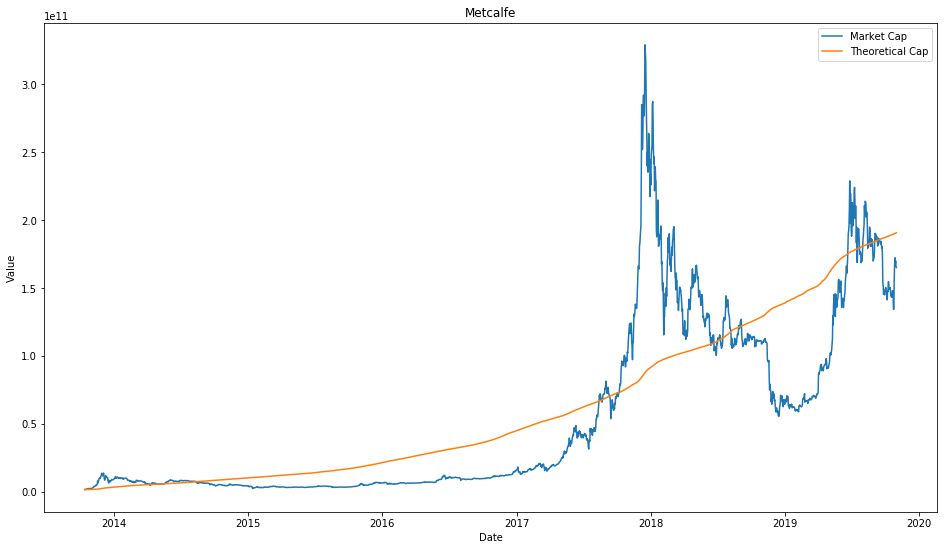

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
_ = ax.plot(final_data.index, final_data.MarketCap, label='Market Cap')
_ = ax.plot(final_data.index, final_data.Theo_Cap, label='Theoretical Cap')

_ = ax.legend()
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Value')
_ = ax.set_title('Metcalfe')

plt.savefig('Metcalfe.png')

In [10]:
final_data['Theo_Price'] = final_data['Theo_Cap'] / final_data['Supply']
final_data.head()

,Supply,MarketCap,Price,Users,Theo_Cap,Theo_Price
Date,,,,,,
2013-10-14,1.184266e+07,1.602777e+09,135.339195,485945.0,1.602777e+09,135.339195
2013-10-15,1.184916e+07,1.676585e+09,141.493909,485945.0,1.602777e+09,135.264953
2013-10-16,1.185441e+07,1.639797e+09,138.327922,485945.0,1.602777e+09,135.205048
2013-10-17,1.185859e+07,1.704638e+09,143.747134,485945.0,1.602777e+09,135.157447
2013-10-18,1.186339e+07,1.812436e+09,152.775572,485945.0,1.602777e+09,135.102761


In [11]:
# Price and Thoeretical Price of current date
print('Current Price and Theoretical Price: ')
final_data.iloc[-1, [2,5]]

Current Price and Theoretical Price: 


Price          9155.277299
Theo_Price    10575.965718
Name: 2019-10-31 00:00:00, dtype: float64

In [10]:
final_data['Premium/Discount'] = (final_data['Price'] - final_data['Theo_Price']) / final_data['Theo_Price']
final_data.head()

,Supply,MarketCap,Price,Users,Theo_Cap,Theo_Price,Premium/Discount
Date,,,,,,,
2013-10-14,1.184266e+07,1.602777e+09,135.339195,485945.0,1.602777e+09,135.339195,0.000000
2013-10-15,1.184916e+07,1.676585e+09,141.493909,485945.0,1.602777e+09,135.264953,0.046050
2013-10-16,1.185441e+07,1.639797e+09,138.327922,485945.0,1.602777e+09,135.205048,0.023097
2013-10-17,1.185859e+07,1.704638e+09,143.747134,485945.0,1.602777e+09,135.157447,0.063553
2013-10-18,1.186339e+07,1.812436e+09,152.775572,485945.0,1.602777e+09,135.102761,0.130810


In [11]:
# record of the day has max premium
final_data.loc[final_data['Premium/Discount'] == max(final_data['Premium/Discount']), :]

,Supply,MarketCap,Price,Users,Theo_Cap,Theo_Price,Premium/Discount
Date,,,,,,,
2013-11-29,1.205506e+07,1.360686e+10,1128.725488,690809.111111,2.339685e+09,194.083147,4.81568


In [12]:
# record of the day has min premium
final_data.loc[final_data['Premium/Discount'] == min(final_data['Premium/Discount']), :]

,Supply,MarketCap,Price,Users,Theo_Cap,Theo_Price,Premium/Discount
Date,,,,,,,
2015-08-24,1.453461e+07,3.080698e+09,211.955918,4.085491e+06,1.566613e+10,1077.849491,-0.803353


In [13]:
print('Average Premium: ', np.mean(final_data.loc[final_data['Premium/Discount'] > 0, 'Premium/Discount']))
print('Average Discount: ', np.mean(final_data.loc[final_data['Premium/Discount'] < 0, 'Premium/Discount']))

Average Premium:  0.6725003165051628
Average Discount:  -0.541326008603136


In [14]:
Current_Bitcoin_Price = round(final_data.iloc[-1, 2], 4)
Current_Bitcoin_Theoretical_Price = round(final_data.iloc[-1, 5], 4)
Max_Premium = round(final_data.loc[final_data['Premium/Discount'] == max(final_data['Premium/Discount']), 'Premium/Discount'],4).values[0]
Max_Discount = round(final_data.loc[final_data['Premium/Discount'] == min(final_data['Premium/Discount']), 'Premium/Discount'],4).values[0]
Average_Premium = round(np.mean(final_data.loc[final_data['Premium/Discount'] > 0, 'Premium/Discount']), 4)
Average_Discount = round(np.mean(final_data.loc[final_data['Premium/Discount'] < 0, 'Premium/Discount']), 4)
report = ['Start Date', 'On Chain/Off Chain', 'Current Bitcoin Price', 'Current Bitcoin Theoretical Price', \
          'Current Premium/Discount', 'Max Premium', 'Max Discount', 'Average Premium', 'Average Discount']
value = []
value.extend([start_date, marketCap_selection, Current_Bitcoin_Price, Current_Bitcoin_Theoretical_Price, \
              str(round((Current_Bitcoin_Price - Current_Bitcoin_Theoretical_Price) / Current_Bitcoin_Theoretical_Price,4)*100)+'%', \
              str(Max_Premium * 100) + '%', str(Max_Discount*100)+'%', str(Average_Premium*100)+'%', str(Average_Discount*100)+'%'])
df = []
df.extend([report, value])
df = pd.DataFrame(df)
new_header = df.iloc[0] 
df = df[1:]
df.columns = new_header
df.to_csv('Model Statistics.csv', index = False)